In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv('/home/ensai/Djo/djo.csv')


print("--- Aperçu initial des données ---")
print(f"Dimensions de la base : {df.shape}")
print("\nTypes de données des colonnes :")
print(df.info())

print("\nPremières lignes de la base :")
print(df.head())

print("\nStatistiques descriptives des colonnes numériques :")
print(df.describe())

print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())


# Conversion de la date
df['date_achat'] = pd.to_datetime(df['date_achat'])

--- Aperçu initial des données ---
Dimensions de la base : (10000, 22)

Types de données des colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_achat               10000 non-null  object 
 1   date_achat             10000 non-null  object 
 2   id_produit             10000 non-null  object 
 3   quantité               10000 non-null  int64  
 4   id_fournisseur         10000 non-null  object 
 5   prix_unitaire          10000 non-null  float64
 6   délai_livraison_jours  10000 non-null  int64  
 7   montant_total          10000 non-null  float64
 8   mois                   10000 non-null  int64  
 9   année                  10000 non-null  int64  
 10  jour_semaine           10000 non-null  int64  
 11  catégorie              10000 non-null  object 
 12  marque                 10000 non-null  object 
 13  pri


--- Analyse exploratoire détaillée ---


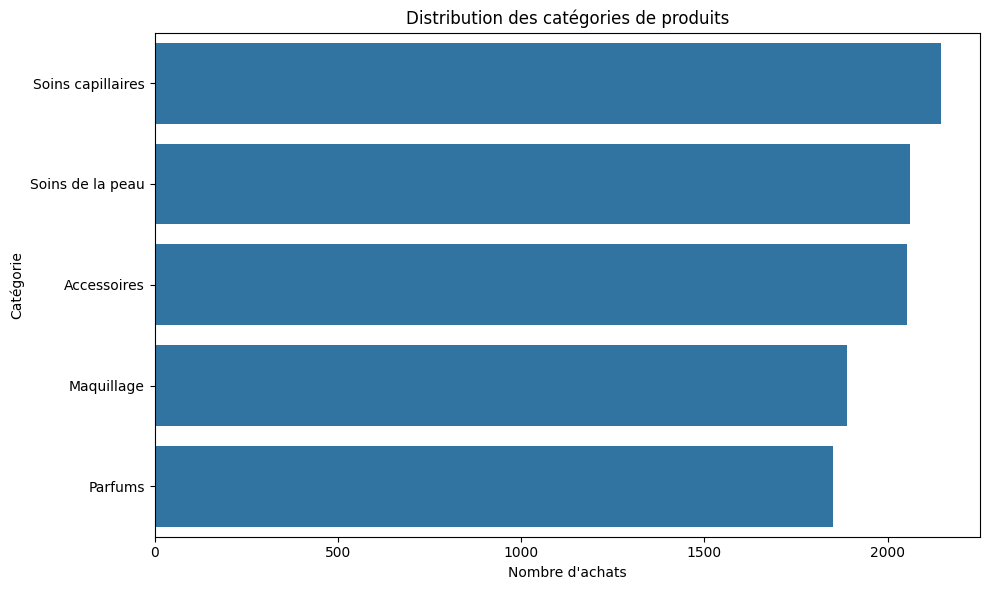

In [26]:
print("\n--- Analyse exploratoire détaillée ---")

# Distribution des catégories de produits
plt.figure(figsize=(10, 6))
sns.countplot(y=df['catégorie'], order=df['catégorie'].value_counts().index)
plt.title('Distribution des catégories de produits')
plt.xlabel('Nombre d\'achats')
plt.ylabel('Catégorie')
plt.tight_layout()
plt.show()

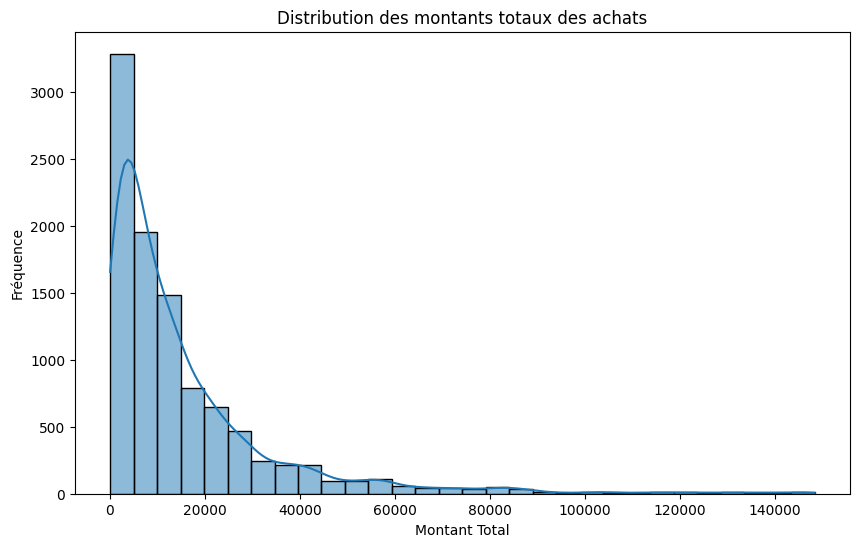

In [27]:
# Distribution des montants totaux
plt.figure(figsize=(10, 6))
sns.histplot(df['montant_total'], kde=True, bins=30)
plt.title('Distribution des montants totaux des achats')
plt.xlabel('Montant Total')
plt.ylabel('Fréquence')
plt.show()


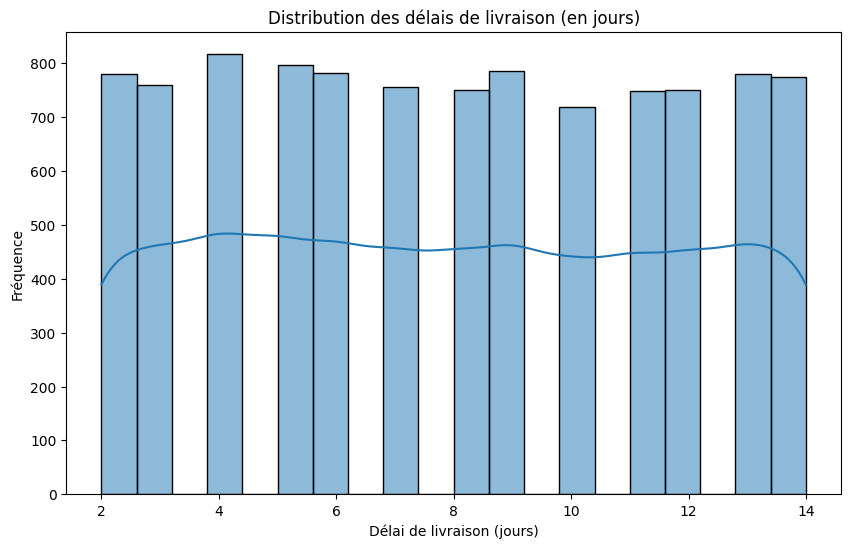

In [28]:
# Distribution des délais de livraison réels
plt.figure(figsize=(10, 6))
sns.histplot(df['délai_livraison_jours'], kde=True, bins=20)
plt.title('Distribution des délais de livraison (en jours)')
plt.xlabel('Délai de livraison (jours)')
plt.ylabel('Fréquence')
plt.show()

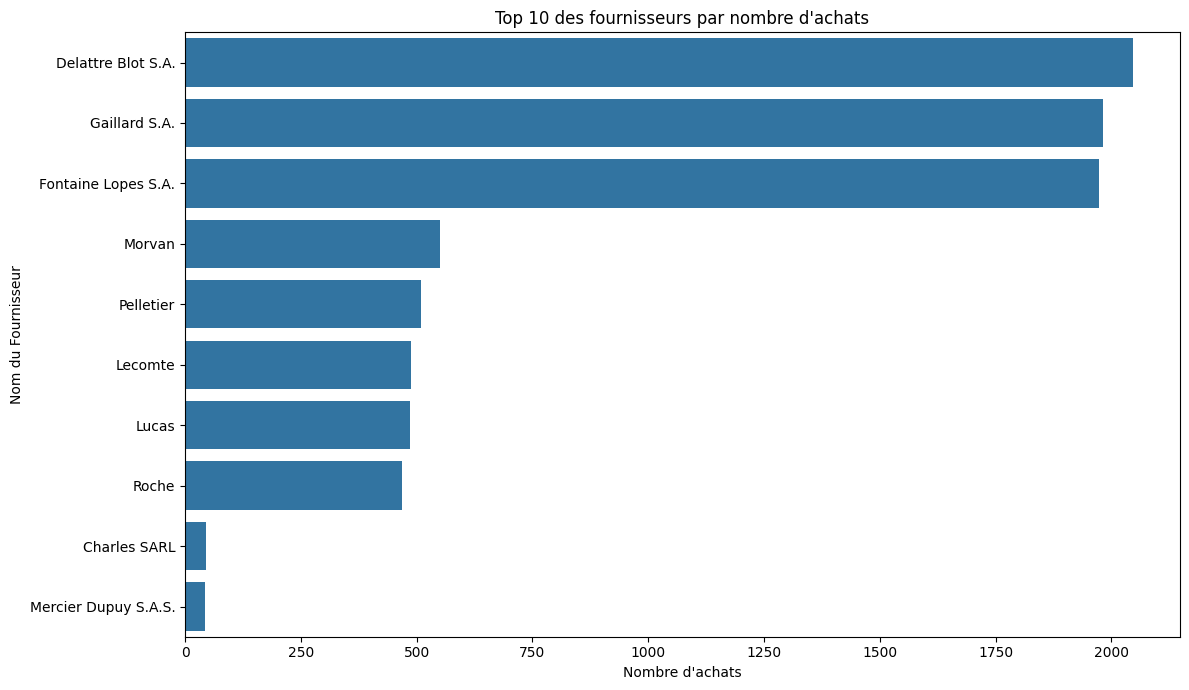

In [29]:

# Top 10 Fournisseurs par nombre d'achats
plt.figure(figsize=(12, 7))
top_fournisseurs = df['nom_fournisseur'].value_counts().nlargest(10)
sns.barplot(x=top_fournisseurs.values, y=top_fournisseurs.index)
plt.title('Top 10 des fournisseurs par nombre d\'achats')
plt.xlabel('Nombre d\'achats')
plt.ylabel('Nom du Fournisseur')
plt.tight_layout()
plt.show()

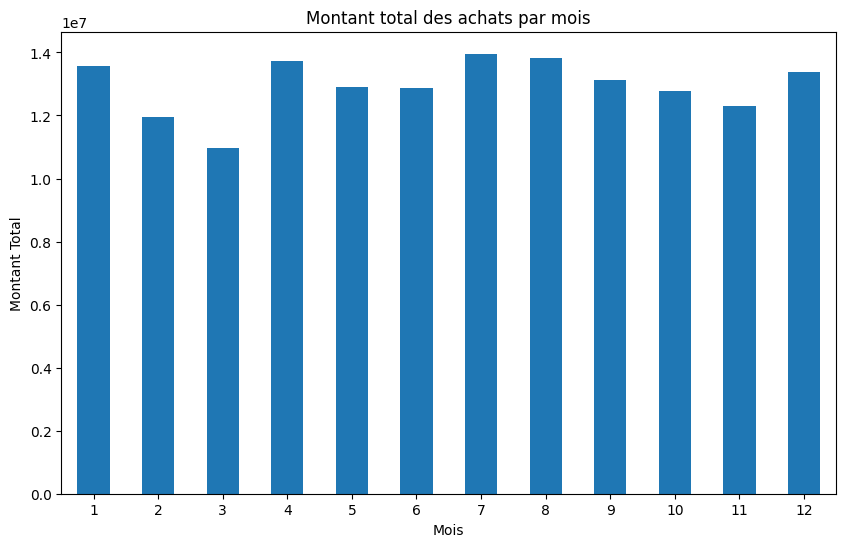

In [30]:
# Montant total des achats par mois
achats_par_mois = df.groupby('mois')['montant_total'].sum()
plt.figure(figsize=(10, 6))
achats_par_mois.plot(kind='bar')
plt.title('Montant total des achats par mois')
plt.xlabel('Mois')
plt.ylabel('Montant Total')
plt.xticks(rotation=0)
plt.show()


In [ ]:

print("\n--- Classification des fournisseurs ---")


supplier_features = df.groupby('id_fournisseur').agg(
    nom_fournisseur=('nom_fournisseur', 'first'),
    fiabilite=('fiabilité', 'mean'), 
    delai_moyen_livraison_specifique=('délai_moyen_jours', 'mean'), 
    nombre_achats=('id_achat', 'count'),
    montant_total_achats=('montant_total', 'sum'),
    quantite_totale_achetee=('quantité', 'sum'),
    prix_unitaire_moyen_paye=('prix_unitaire', 'mean'),
    delai_livraison_observe_moyen=('délai_livraison_jours', 'mean') 
).reset_index()

supplier_features['montant_moyen_par_achat'] = supplier_features['montant_total_achats'] / supplier_features['nombre_achats']

print("\nCaractéristiques agrégées par fournisseur :")
print(supplier_features.head())


--- Classification des fournisseurs ---

Caractéristiques agrégées par fournisseur :
  id_fournisseur  nom_fournisseur  fiabilite  \
0           S001  Lecomte et Fils       0.84   
1           S002           Morvan       0.86   
2           S003  Germain et Fils       0.85   
3           S004         Philippe       0.57   
4           S005            Blanc       0.65   

   delai_moyen_livraison_specifique  nombre_achats  montant_total_achats  \
0                              10.0             40             576134.75   
1                               9.0            551            8911703.35   
2                              10.0             29             433349.20   
3                               9.0             32             605874.40   
4                              13.0             42             813314.30   

   quantite_totale_achetee  prix_unitaire_moyen_paye  \
0                     3935                157.786250   
1                    56800                155.404682   


In [ ]:
import plotly.express as px


if 'supplier_features' not in locals() and 'df' in locals():
    print("Recalcul de supplier_features...")
    supplier_features = df.groupby('id_fournisseur').agg(
        nom_fournisseur=('nom_fournisseur', 'first'),
        fiabilite=('fiabilité', 'mean'), # Devrait être unique par fournisseur
        delai_moyen_livraison_specifique=('délai_moyen_jours', 'mean'), # Devrait être unique
        nombre_achats=('id_achat', 'count'),
        montant_total_achats=('montant_total', 'sum')

    ).reset_index()
elif 'supplier_features' not in locals() and 'df' not in locals():
    print("Erreur : DataFrame 'df' et 'supplier_features' non trouvés. Veuillez exécuter les étapes précédentes.")
    exit()


print("\n--- Création du graphique interactif avec Plotly pour la classification des fournisseurs ---")

fig_plotly = px.scatter(
    supplier_features,
    x='fiabilite',
    y='delai_moyen_livraison_specifique',
    size='nombre_achats',  
    color='nom_fournisseur',
    hover_name='nom_fournisseur',  
    hover_data={ 
        'fiabilite': ':.2f',
        'delai_moyen_livraison_specifique': True, 
        'nombre_achats': True,
        'montant_total_achats': ':,.0f'
    },
    title='Fiabilité vs. Délai moyen de livraison des fournisseurs (Interactif)',
    labels={
        'fiabilite': 'Fiabilité du fournisseur',
        'delai_moyen_livraison_specifique': 'Délai moyen de livraison spécifié (jours)',
        'nombre_achats': 'Nombre d\'achats',
        'nom_fournisseur': 'Fournisseur'
    }
)


fig_plotly.update_layout(
    xaxis_title='Fiabilité du fournisseur',
    yaxis_title='Délai moyen de livraison spécifié (jours)',
    legend_title='Fournisseurs',

)
fig_plotly.update_traces(marker=dict(sizemin=5))

fig_plotly.show()


--- Création du graphique interactif avec Plotly pour la classification des fournisseurs ---



--- Classification des fournisseurs avec K-Means (adapté) ---

Détermination du nombre optimal de clusters (Méthode du Coude)...


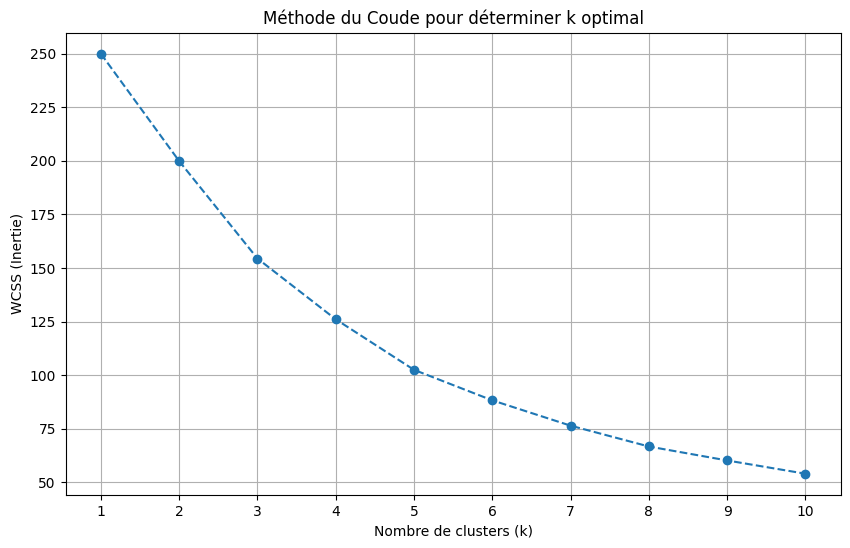


Application de K-Means avec k=4 clusters...

Classification par K-Means (exemple) :
   nom_fournisseur  cluster_kmeans
0  Lecomte et Fils               0
1           Morvan               0
2  Germain et Fils               0
3         Philippe               2
4            Blanc               2

Caractéristiques moyennes par cluster :
                fiabilite  delai_moyen_livraison_specifique  \
cluster_kmeans                                                
0                0.837647                          9.352941   
1                0.686471                          5.117647   
2                0.699231                         10.769231   
3                0.640000                          7.000000   

                delai_livraison_observe_moyen  montant_moyen_par_achat  \
cluster_kmeans                                                           
0                                    8.302393             13058.841108   
1                                    7.633261             15842

In [ ]:
from sklearn.preprocessing import StandardScaler

supplier_feature = df.groupby('id_fournisseur').agg(
    nom_fournisseur=('nom_fournisseur', 'first'),
    fiabilite=('fiabilité', 'mean'),
    delai_moyen_livraison_specifique=('délai_moyen_jours', 'mean'),
    nombre_achats=('id_achat', 'count'),
    montant_total_achats=('montant_total', 'sum'),
    quantite_totale_achetee=('quantité', 'sum'),
    prix_unitaire_moyen_paye=('prix_unitaire', 'mean'),
    delai_livraison_observe_moyen=('délai_livraison_jours', 'mean'),
    delai_livraison_observe_std=('délai_livraison_jours', 'std'),
    ville=('ville', 'first'),
    pays=('pays', 'first')
).reset_index()

supplier_feature['delai_livraison_observe_std'].fillna(0, inplace=True)
supplier_feature['montant_moyen_par_achat'] = supplier_feature['montant_total_achats'] / supplier_feature['nombre_achats']

print("\n--- Classification des fournisseurs avec K-Means (adapté) ---")


features_for_clustering = [
    'fiabilite',
    'delai_moyen_livraison_specifique',
    'delai_livraison_observe_moyen',
    'montant_moyen_par_achat',
    'nombre_achats'
]
X_cluster = supplier_feature[features_for_clustering].copy()
)
for col in X_cluster.columns:
    if X_cluster[col].isnull().any():
        print(f"Attention: Valeurs NaN trouvées dans la colonne '{col}' pour le clustering. Remplacement par la moyenne.")
        X_cluster[col].fillna(X_cluster[col].mean(), inplace=True)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


print("\nDétermination du nombre optimal de clusters (Méthode du Coude)...")
wcss = []
k_range = range(1, 11)

for i in k_range:
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans_elbow.fit(X_scaled)
    wcss.append(kmeans_elbow.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Méthode du Coude pour déterminer k optimal')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS (Inertie)')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()
try:
    optimal_k = int(input("D'après le graphique du coude, quel est le nombre optimal de clusters (k) ? Entrez un nombre entier : "))
    if not (1 <= optimal_k <= 10): # Vérifier si k est dans la plage testée
        print("Nombre de clusters hors de la plage testée. Utilisation de k=3 par défaut.")
        optimal_k = 3
except ValueError:
    print("Entrée invalide. Utilisation de k=3 par défaut.")
    optimal_k = 3


print(f"\nApplication de K-Means avec k={optimal_k} clusters...")
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
supplier_feature['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

print("\nClassification par K-Means (exemple) :")
print(supplier_feature[['nom_fournisseur', 'cluster_kmeans']].head())


print("\nCaractéristiques moyennes par cluster :")
cluster_analysis = supplier_feature.groupby('cluster_kmeans')[features_for_clustering].mean()
print(cluster_analysis)



In [ ]:

supplier_feature['cluster_kmeans'] = supplier_feature['cluster_kmeans'].astype('category')

print("\nCréation du graphique interactif Plotly pour les clusters K-Means...")
fig_kmeans_plotly = px.scatter(
    supplier_feature,
    x='fiabilite',  # Axe X
    y='delai_livraison_observe_moyen',
    color='cluster_kmeans',
    size='nombre_achats',
    hover_name='nom_fournisseur',
    hover_data={
        'fiabilite': ':.2f',
        'delai_moyen_livraison_specifique': ':.1f',
        'delai_livraison_observe_moyen': ':.1f',
        'montant_moyen_par_achat': ':,.0f',
        'nombre_achats': True,
        'cluster_kmeans': True, 
        'ville': True,
        'pays': True
    },
    title=f'Clusters de fournisseurs par K-Means (k={optimal_k})',
    labels={
        'fiabilite': 'Fiabilité',
        'delai_livraison_observe_moyen': 'Délai Observé Moyen (j)',
        'nombre_achats': 'Nb Achats',
        'cluster_kmeans': 'Cluster'
    },
    color_discrete_sequence=px.colors.qualitative.Vivid # Autre palette de couleurs
)

fig_kmeans_plotly.update_layout(
    legend_title_text='Cluster K-Means'
)
fig_kmeans_plotly.update_traces(marker=dict(sizemin=5))
fig_kmeans_plotly.show()

print("\nScript de classification K-Means et visualisation Plotly terminé.")


Création du graphique interactif Plotly pour les clusters K-Means...



Script de classification K-Means et visualisation Plotly terminé.
